In [1]:
%autosave 0

Autosave disabled


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy.stats import spearmanr
from pysentimiento import create_analyzer

%matplotlib inline

## Contents
1. **Data Overview.** 
2. **RoBERTa model**
3. **Correlation of text comments with a numerical rating.**
4. **Products/sellers with best/worst reviews.**

# 1) Data Overwiew
Excluding np.NaN where necessary is also done here.

In [3]:
df = pd.read_csv('order_reviews.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   review_id                100000 non-null  object
 1   order_id                 100000 non-null  object
 2   review_score             100000 non-null  int64 
 3   review_comment_title     11715 non-null   object
 4   review_comment_message   41753 non-null   object
 5   review_creation_date     100000 non-null  object
 6   review_answer_timestamp  100000 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


In [5]:
df.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [6]:
# we need only rows with actual text comments
df.dropna(subset=['review_comment_message'], inplace=True)

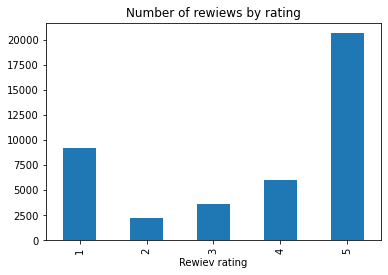

In [7]:
# most common rating is 5
ax = df.review_score.value_counts().sort_index().plot(kind='bar', title='Number of rewiews by rating')
ax.set_xlabel('Rewiev rating')
plt.show()

# 2) RoBERTa model 
Base model is BERTabaporu, a RoBERTa model trained in Portuguese tweets. Fameous transformer architecture.<br> 135M parameters, fine-tuned specifically for our task. <br>https://huggingface.co/pysentimiento/bertweet-pt-sentiment

In [8]:
analyzer = create_analyzer(task="sentiment", lang="pt")

/home/petewojtczak/anaconda3/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [9]:
%%time
for index, row in df.iterrows():
    output = analyzer.predict(row.review_comment_message)
    df.loc[index, 'sentiment'] = output.output
    probabilities = output.probas
    df.loc[index, 'POS'] = probabilities['POS']
    df.loc[index, 'NEU'] = probabilities['NEU']
    df.loc[index, 'NEG'] = probabilities['NEG']

CPU times: user 2h 30min 53s, sys: 23.2 s, total: 2h 31min 16s
Wall time: 27min 19s


In [10]:
df.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,sentiment,POS,NEU,NEG
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06,NEU,0.083059,0.865634,0.051306
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53,POS,0.989135,0.008621,0.002244
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelh...,2018-05-22 00:00:00,2018-05-23 16:45:47,NEG,0.040093,0.322280,0.637627
12,4b49719c8a200003f700d3d986ea1a19,9d6f15f95d01e79bd1349cc208361f09,4,NaN,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",2018-02-16 00:00:00,2018-02-20 10:52:22,NEG,0.030705,0.360272,0.609023
15,3948b09f7c818e2d86c9a546758b2335,e51478e7e277a83743b6f9991dbfa3fb,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes...",2018-05-23 00:00:00,2018-05-24 03:00:01,NEU,0.108078,0.840541,0.051380


# 3) Correlation of text comments with a numerical rating

## 3.1) Visual outlook

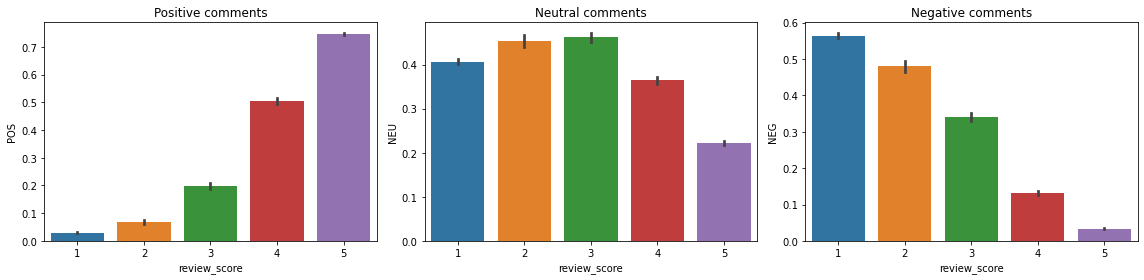

CPU times: user 1.3 s, sys: 143 ms, total: 1.45 s
Wall time: 1.26 s


In [11]:
%%time
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
sns.barplot(data=df, x='review_score', y='POS', ax=axs[0])
sns.barplot(data=df, x='review_score', y='NEU', ax=axs[1])
sns.barplot(data=df, x='review_score', y='NEG', ax=axs[2])
axs[0].set_title('Positive comments')
axs[1].set_title('Neutral comments')
axs[2].set_title('Negative comments')
plt.tight_layout()
plt.show()

## 3.2) Spearmans rho (corr coeff)
We can calculate formal corelation coeff appropriate for two ordinal variables.

In [12]:
# first, we need to move towards numbers 
sentiment_mapping = {'NEG': 0, 'NEU': 1, 'POS': 2}

for index, row in df.iterrows():
    df.loc[index, 'NUM_sentiment'] = sentiment_mapping.get(row.sentiment)

In [13]:
# this is the corr coeff appriopriate here
rho, p_value = spearmanr(df.NUM_sentiment, df.review_score)
print("Spearman's rho:", rho)
print("p-value:", p_value)

Spearman's rho: 0.6932568231839278
p-value: 0.0


Clearly, correlation is there and it is strong (Spearman's rho ranges from -1 to 1). Note that Null Hypothesis here is 'no correlation' and probability under the Null (p-value) is equal:

In [14]:
print("{:.20f}".format(p_value))

0.00000000000000000000


# 4) Products/sellers with best/worst reviews

NOTE: Each comment is essentially associated with all order items that comes with an order_id. All these items (products) will be therefore associated with this comment.

In [15]:
df.head(3)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,sentiment,POS,NEU,NEG,NUM_sentiment
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06,NEU,0.083059,0.865634,0.051306,1.0
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53,POS,0.989135,0.008621,0.002244,2.0
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelh...,2018-05-22 00:00:00,2018-05-23 16:45:47,NEG,0.040093,0.322280,0.637627,0.0


In [16]:
order_items = pd.read_csv('order_items.csv')
order_items.head(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87


We will exclude dupicates assiciated with buying same products in one order.

In [17]:
order_items = order_items.drop_duplicates(subset=['order_id', 'product_id'], keep='first')

We need a container for sellers in order to conduct analysis.

In [18]:
seller = order_items.set_index('seller_id')
seller = seller.assign(POS=0, NEU=0, NEG=0)
seller = seller[['POS', 'NEU', 'NEG']]
seller = seller[~seller.index.duplicated(keep='first')]

We also need a container for products in order to conduct analysis.

In [19]:
product = order_items.set_index('product_id')
product = product.assign(POS=0, NEU=0, NEG=0)
product = product[['POS', 'NEU', 'NEG']]
product = product[~product.index.duplicated(keep='first')]

Now we need to cycle through our rewiews and fill created containers accordingly, as given below (essentialy we are just counting stuff along the way).

In [20]:
%%time
df.set_index('order_id', inplace=True)
order_items.set_index('order_id', inplace=True)
for index, row in df.iterrows():
    if index not in order_items.index:
        continue
    if isinstance(order_items.loc[index], pd.Series):
        if row.sentiment == 'POS':
            product.loc[order_items.loc[index].product_id, 'POS'] += 1
            seller.loc[order_items.loc[index].seller_id, 'POS'] += 1
        elif row.sentiment == 'NEU':
            product.loc[order_items.loc[index].product_id, 'NEU'] += 1
            seller.loc[order_items.loc[index].seller_id, 'NEU'] += 1
        else:
            product.loc[order_items.loc[index].product_id, 'NEG'] += 1
            seller.loc[order_items.loc[index].seller_id, 'NEG'] += 1
    else:
        if row.sentiment == 'POS':
            for item in order_items.loc[index].iterrows():
                product.loc[item[1].product_id, 'POS'] += 1
                seller.loc[item[1].seller_id, 'POS'] += 1
        elif row.sentiment == 'NEU':
            for item in order_items.loc[index].iterrows():
                product.loc[item[1].product_id, 'NEU'] += 1
                seller.loc[item[1].seller_id, 'NEU'] += 1
        else:
            for item in order_items.loc[index].iterrows():
                product.loc[item[1].product_id, 'NEG'] += 1
                seller.loc[item[1].seller_id, 'NEG'] += 1

CPU times: user 32.1 s, sys: 176 ms, total: 32.3 s
Wall time: 32.1 s


## 4.1) Seller analysis

In [21]:
seller['total_rewievs'] = seller['POS'] + seller['NEU'] + seller['NEG']
seller['POS_ratio'] = seller['POS'] / seller['total_rewievs']
seller['NEG_ratio'] = seller['NEG'] / seller['total_rewievs']

### Sellers with most positive comments (nominal)

In [22]:
seller.sort_values(by='POS', ascending=False).head(10)

,POS,NEU,NEG,total_rewievs,POS_ratio,NEG_ratio
seller_id,,,,,,
4a3ca9315b744ce9f8e9374361493884,448,299,243,990,0.452525,0.245455
6560211a19b47992c3666cc44a7e94c0,438,307,213,958,0.457203,0.222338
1f50f920176fa81dab994f9023523100,394,222,104,720,0.547222,0.144444
cc419e0650a3c5ba77189a1882b7556a,391,226,129,746,0.524129,0.172922
7a67c85e85bb2ce8582c35f2203ad736,315,109,77,501,0.628743,0.153693
da8622b14eb17ae2831f4ac5b9dab84a,303,182,100,585,0.517949,0.170940
4869f7a5dfa277a7dca6462dcf3b52b2,226,150,83,459,0.492375,0.180828
955fee9216a65b617aa5c0531780ce60,224,187,80,491,0.456212,0.162933
3d871de0142ce09b7081e2b9d1733cb1,212,130,103,445,0.476404,0.231461


### Sellers with best share of positive comments
Only sellers with al least 31 comments are listed. Please tweak code for desired minimal numer of total rewievs.

In [23]:
seller[seller['total_rewievs'] > 30].sort_values(by='POS_ratio', ascending=False).head(10)

,POS,NEU,NEG,total_rewievs,POS_ratio,NEG_ratio
seller_id,,,,,,
744dac408745240a2c2528fb1b6028f3,34,4,1,39,0.871795,0.025641
d921b68bf747894be13a97ae52b0f386,26,3,2,31,0.838710,0.064516
12b9676b00f60f3b700e83af21824c0e,55,9,5,69,0.797101,0.072464
a5cba26a62b8b4d0145b68b841e62e7f,24,8,0,32,0.750000,0.000000
ac3508719a1d8f5b7614b798f70af136,35,11,3,49,0.714286,0.061224
6cd68b3ed6d59aaa9fece558ad360c0a,42,14,4,60,0.700000,0.066667
0509040ea3fe50071181bbc359eb7738,24,7,4,35,0.685714,0.114286
7681ef142fd2c19048da7430856b5588,24,9,2,35,0.685714,0.057143
1c129092bf23f28a5930387c980c0dfc,76,28,8,112,0.678571,0.071429


### Sellers with most negative comments (nominal)

In [24]:
seller.sort_values(by='NEG', ascending=False).head(10)

,POS,NEU,NEG,total_rewievs,POS_ratio,NEG_ratio
seller_id,,,,,,
4a3ca9315b744ce9f8e9374361493884,448,299,243,990,0.452525,0.245455
6560211a19b47992c3666cc44a7e94c0,438,307,213,958,0.457203,0.222338
7c67e1448b00f6e969d365cea6b010ab,140,222,159,521,0.268714,0.305182
cc419e0650a3c5ba77189a1882b7556a,391,226,129,746,0.524129,0.172922
ea8482cd71df3c1969d7b9473ff13abc,199,203,115,517,0.384913,0.222437
1f50f920176fa81dab994f9023523100,394,222,104,720,0.547222,0.144444
3d871de0142ce09b7081e2b9d1733cb1,212,130,103,445,0.476404,0.231461
da8622b14eb17ae2831f4ac5b9dab84a,303,182,100,585,0.517949,0.170940
1025f0e2d44d7041d6cf58b6550e0bfa,170,156,88,414,0.410628,0.212560


### Sellers with worst share of negative comments
Only sellers with at least 31 comments are listed. Please tweak code for desired minimal number of total rewievs.

In [25]:
seller[seller['total_rewievs'] > 30].sort_values(by='NEG_ratio', ascending=False).head(10)

,POS,NEU,NEG,total_rewievs,POS_ratio,NEG_ratio
seller_id,,,,,,
1ca7077d890b907f89be8c954a02686a,2,24,59,85,0.023529,0.694118
2eb70248d66e0e3ef83659f71b244378,16,40,74,130,0.123077,0.569231
54965bbe3e4f07ae045b90b0b8541f52,7,16,25,48,0.145833,0.520833
a49928bcdf77c55c6d6e05e09a9b4ca5,12,15,26,53,0.226415,0.490566
710e3548e02bc1d2831dfc4f1b5b14d4,16,20,32,68,0.235294,0.470588
972d0f9cf61b499a4812cf0bfa3ad3c4,14,14,23,51,0.274510,0.450980
b14db04aa7881970e83ffa9426897925,13,6,15,34,0.382353,0.441176
a7f13822ceb966b076af67121f87b063,6,17,18,41,0.146341,0.439024
dc8798cbf453b7e0f98745e396cc5616,12,7,14,33,0.363636,0.424242


## 4.2) Product analysis

In [26]:
product['total_rewievs'] = product['POS'] + product['NEU'] + product['NEG']
product['POS_ratio'] = product['POS'] / product['total_rewievs']
product['NEG_ratio'] = product['NEG'] / product['total_rewievs']

### Products with most positive comments (nominal)

In [27]:
product.sort_values(by='POS', ascending=False).head(10)

,POS,NEU,NEG,total_rewievs,POS_ratio,NEG_ratio
product_id,,,,,,
99a4788cb24856965c36a24e339b6058,108,66,58,232,0.465517,0.250000
422879e10f46682990de24d770e7f83d,94,42,23,159,0.591195,0.144654
389d119b48cf3043d311335e499d9c6b,89,40,21,150,0.593333,0.140000
368c6c730842d78016ad823897a372db,81,51,19,151,0.536424,0.125828
2b4609f8948be18874494203496bc318,75,34,18,127,0.590551,0.141732
aca2eb7d00ea1a7b8ebd4e68314663af,73,59,19,151,0.483444,0.125828
53759a2ecddad2bb87a079a1f1519f73,71,47,26,144,0.493056,0.180556
154e7e31ebfa092203795c972e5804a6,62,39,13,114,0.543860,0.114035
d1c427060a0f73f6b889a5c7c61f2ac4,62,59,19,140,0.442857,0.135714


### Products with best share of positive comments
Only products with al least 31 comments are listed. Please tweak code for desired minimal number of total rewievs.

In [28]:
product[product['total_rewievs'] > 30].sort_values(by='POS_ratio', ascending=False).head(10)

,POS,NEU,NEG,total_rewievs,POS_ratio,NEG_ratio
product_id,,,,,,
f1c7f353075ce59d8a6f3cf58f419c9c,59,22,4,85,0.694118,0.047059
ec2d43cc59763ec91694573b31f1c29a,49,18,4,71,0.690141,0.056338
431d674f9a4fbd0957ecf6ba3fcb6899,21,7,3,31,0.677419,0.096774
617186c3d97ea56c9c683a8a3974e8c1,25,6,6,37,0.675676,0.162162
595fac2a385ac33a80bd5114aec74eb8,27,8,5,40,0.675000,0.125000
29427de7f8a9ee983d9dbc51cec569b4,28,5,9,42,0.666667,0.214286
777d2e438a1b645f3aec9bd57e92672c,30,11,4,45,0.666667,0.088889
629e019a6f298a83aeecc7877964f935,21,9,3,33,0.636364,0.090909
2028bf1b01cafb2d2b1901fca4083222,34,12,8,54,0.629630,0.148148


### Products with most negative comments (nominal)

In [29]:
product.sort_values(by='NEG', ascending=False).head(10)

,POS,NEU,NEG,total_rewievs,POS_ratio,NEG_ratio
product_id,,,,,,
99a4788cb24856965c36a24e339b6058,108,66,58,232,0.465517,0.250000
89b121bee266dcd25688a1ba72eefb61,4,8,31,43,0.093023,0.720930
e0d64dcfaa3b6db5c54ca298ae101d05,24,26,30,80,0.300000,0.375000
7c1bd920dbdf22470b68bde975dd3ccf,52,31,27,110,0.472727,0.245455
53759a2ecddad2bb87a079a1f1519f73,71,47,26,144,0.493056,0.180556
84f456958365164420cfc80fbe4c7fab,23,17,25,65,0.353846,0.384615
b1d207586fca400a2370d50a9ba1da98,1,8,25,34,0.029412,0.735294
422879e10f46682990de24d770e7f83d,94,42,23,159,0.591195,0.144654
b5e13c9a353102f79c6206ff5cb61a50,6,14,23,43,0.139535,0.534884


### Products with worst share of negative comments
Only products with at least 31 comments are listed. Please tweak code for desired minimal number of total rewievs.

In [30]:
product[product['total_rewievs'] > 30].sort_values(by='NEG_ratio', ascending=False).head(10)

,POS,NEU,NEG,total_rewievs,POS_ratio,NEG_ratio
product_id,,,,,,
b1d207586fca400a2370d50a9ba1da98,1,8,25,34,0.029412,0.735294
89b121bee266dcd25688a1ba72eefb61,4,8,31,43,0.093023,0.720930
b5e13c9a353102f79c6206ff5cb61a50,6,14,23,43,0.139535,0.534884
84f456958365164420cfc80fbe4c7fab,23,17,25,65,0.353846,0.384615
e0d64dcfaa3b6db5c54ca298ae101d05,24,26,30,80,0.300000,0.375000
165f86fe8b799a708a20ee4ba125c289,23,11,19,53,0.433962,0.358491
4413a608a42bd21bbf9d5abbd58c249a,18,6,11,35,0.514286,0.314286
e7cc48a9daff5436f63d3aad9426f28b,12,10,10,32,0.375000,0.312500
a92930c327948861c015c919a0bcb4a8,23,21,20,64,0.359375,0.312500
